In [1]:
import h5py
import helpers

In [2]:
# read sinbad data
sinbad_file = h5py.File('sinbad_data.h5', 'r')

    cell particle  energyfunction nuclide score          mean     std. dev.
0    135  neutron  27033dc1728744   total  flux  1.247180e-03  1.669876e-05
4    158  neutron  27033dc1728744   total  flux  1.369877e-04  5.044927e-06
8    181  neutron  27033dc1728744   total  flux  4.648878e-05  3.142671e-06
12   204  neutron  27033dc1728744   total  flux  2.323797e-05  2.206733e-06
48   602  neutron  27033dc1728744   total  flux  1.828770e-05  1.979581e-06
60   239  neutron  27033dc1728744   total  flux  1.189558e-05  1.570077e-06
64   262  neutron  27033dc1728744   total  flux  2.756480e-06  6.409373e-07
68   285  neutron  27033dc1728744   total  flux  1.470343e-06  5.541022e-07
72   308  neutron  27033dc1728744   total  flux  3.617121e-07  2.544740e-07
76   331  neutron  27033dc1728744   total  flux  3.358878e-07  2.256653e-07
80   363  neutron  27033dc1728744   total  flux  0.000000e+00  0.000000e+00
84   386  neutron  27033dc1728744   total  flux  0.000000e+00  0.000000e+00
88   398  ne

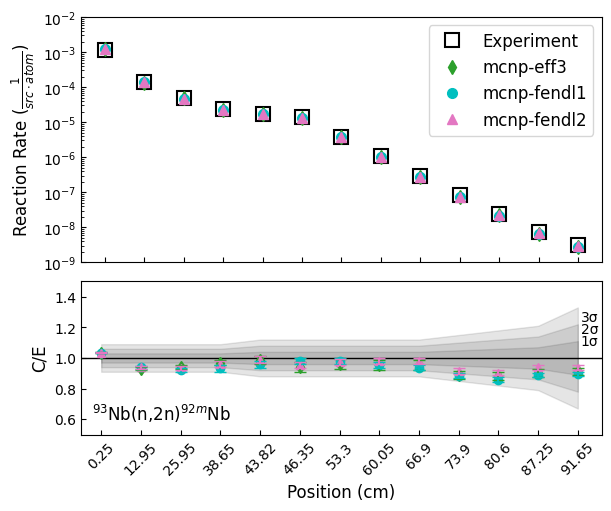

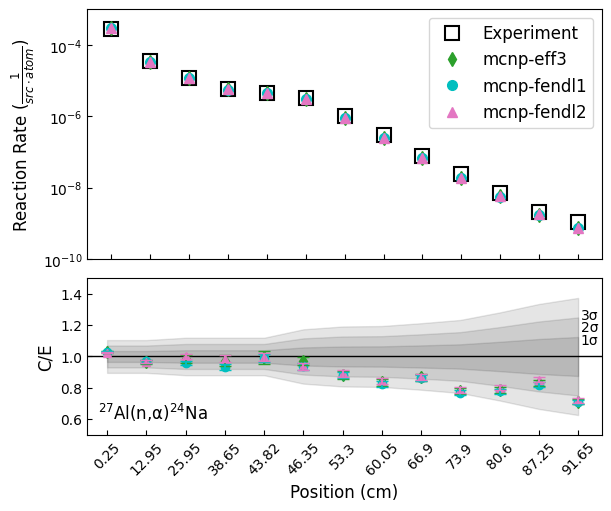

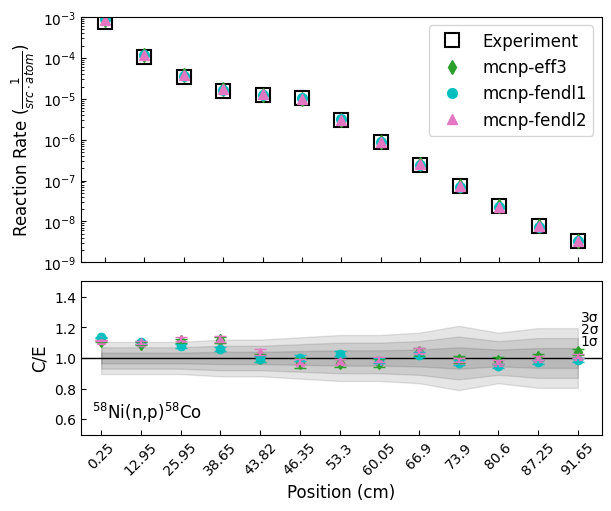

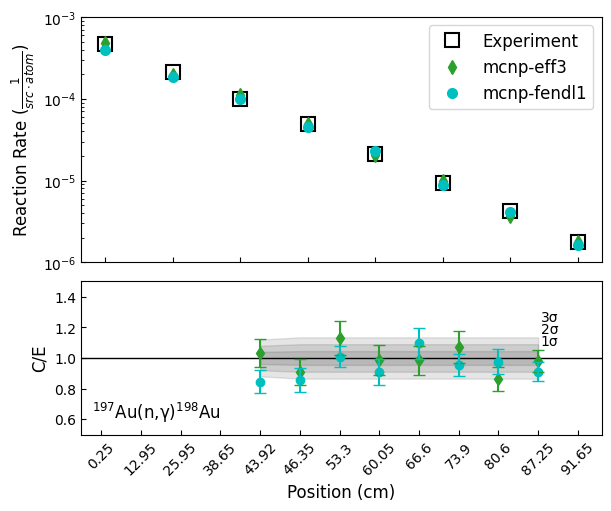

In [3]:
# initialization
path = 'reaction_rates_onaxis/group_1/'
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

for i,foil in enumerate(foil_list):
    measured = sinbad_file[path + f'measured/{foil}/table']
    mcnp_eff3 = sinbad_file[path + f'mcnp-eff3/{foil}/table']
    mcnp_fendl1 = sinbad_file[path + f'mcnp-fendl1/{foil}/table']
    try:
        mcnp_fendl2 = sinbad_file[path + f'mcnp-fendl2/{foil}/table']
    except:
        mcnp_fendl2 = None

    # read openmc results from its statepoint file
    openmc_1 = helpers.get_openmc_tally('reaction_rates_onaxis', 'statepoint.100.h5', f'{foil}_irdff_rr')
    openmc_1 = helpers.postprocess_openmc_foils(openmc_1, 'onaxis_group1')

    # plot
    dtype_label = reaction_labels[i]
    foils_onaxis_group1 = helpers.VisualizeResults()  # the plot has always to be initialized like this
    foils_onaxis_group1.add_measured_data(measured, ylabel, dtype_label)  # measured data have always to be plotted
    foils_onaxis_group1.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
    foils_onaxis_group1.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
    foils_onaxis_group1.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
    foils_onaxis_group1.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')

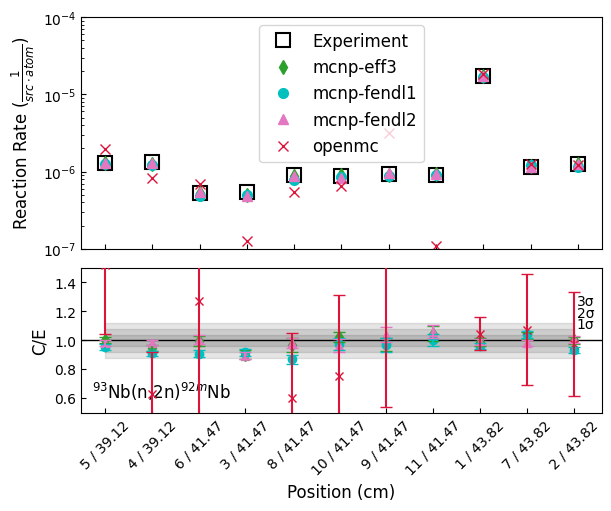

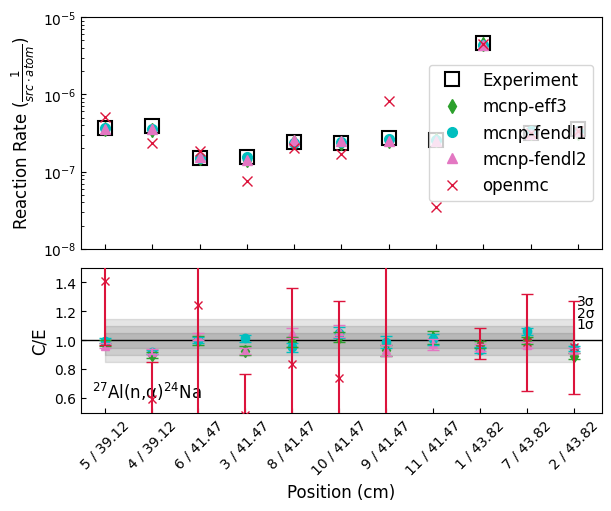

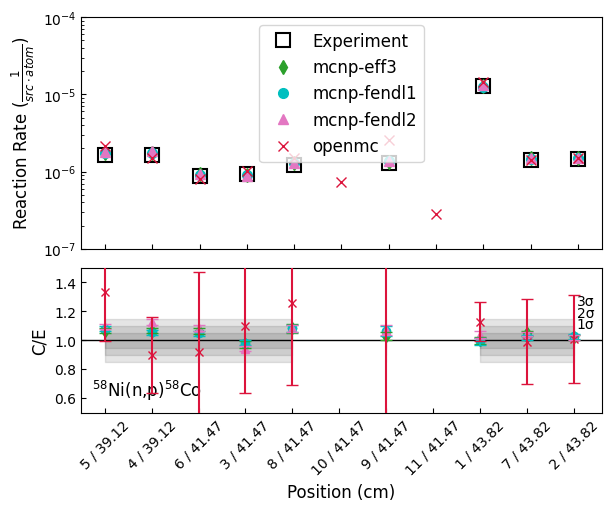

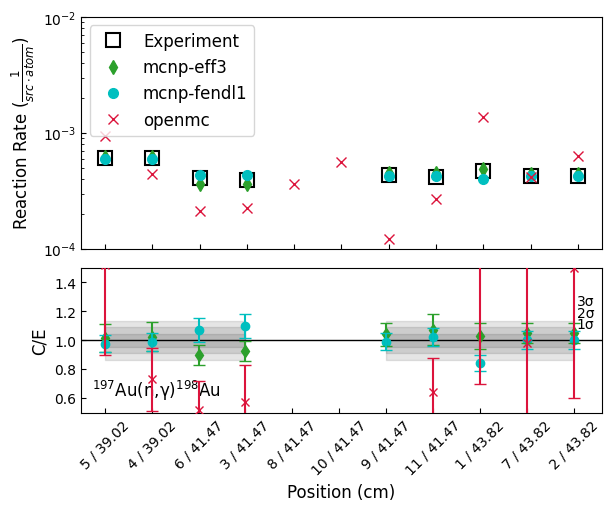

In [4]:
# initialization
path = 'reaction_rates_onaxis/group_2/'
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

for i,foil in enumerate(foil_list):
    measured = sinbad_file[path + f'measured/{foil}/table']
    mcnp_eff3 = sinbad_file[path + f'mcnp-eff3/{foil}/table']
    mcnp_fendl1 = sinbad_file[path + f'mcnp-fendl1/{foil}/table']
    try:
        mcnp_fendl2 = sinbad_file[path + f'mcnp-fendl2/{foil}/table']
    except:
        mcnp_fendl2 = None

    # read openmc results from its statepoint file
    openmc_1 = helpers.get_openmc_tally('reaction_rates_onaxis', 'statepoint.100.h5', f'{foil}_irdff_rr')
    openmc_1 = helpers.postprocess_openmc_foils(openmc_1, 'onaxis_group2')
    
    # plot
    dtype_label = reaction_labels[i]
    foils_onaxis_group2 = helpers.VisualizeResults()  # the plot has always to be initialized like this
    foils_onaxis_group2.add_measured_data(measured, ylabel, dtype_label)  # measured data have always to be plotted
    foils_onaxis_group2.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
    foils_onaxis_group2.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
    foils_onaxis_group2.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
    foils_onaxis_group2.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')

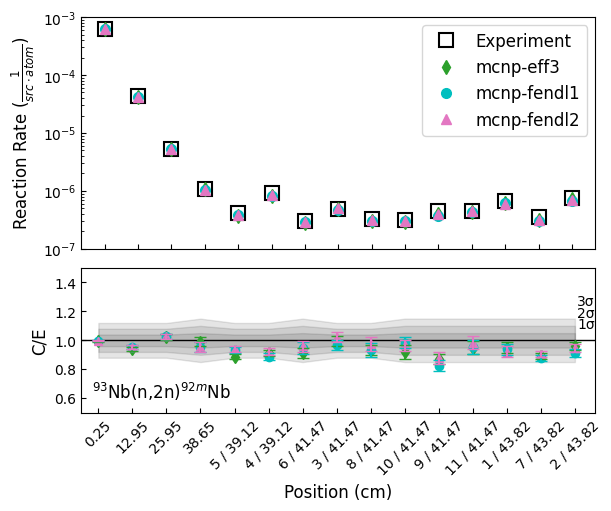

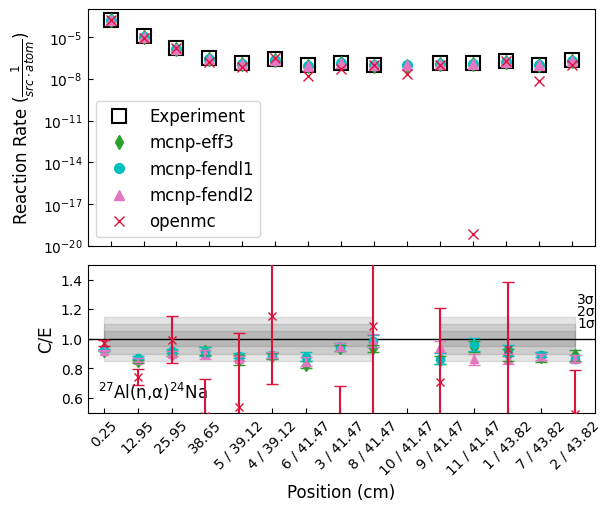

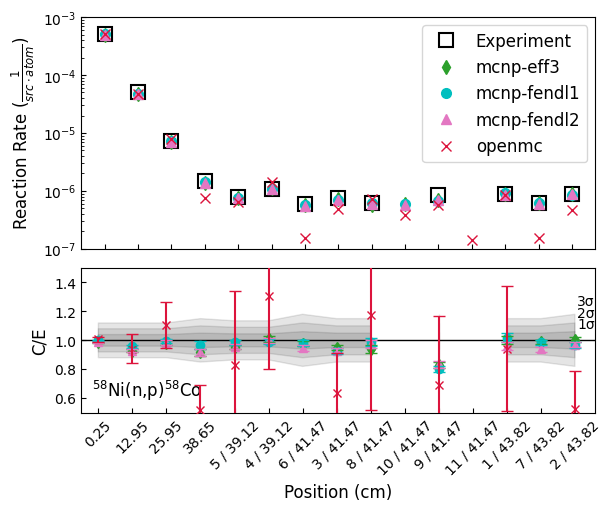

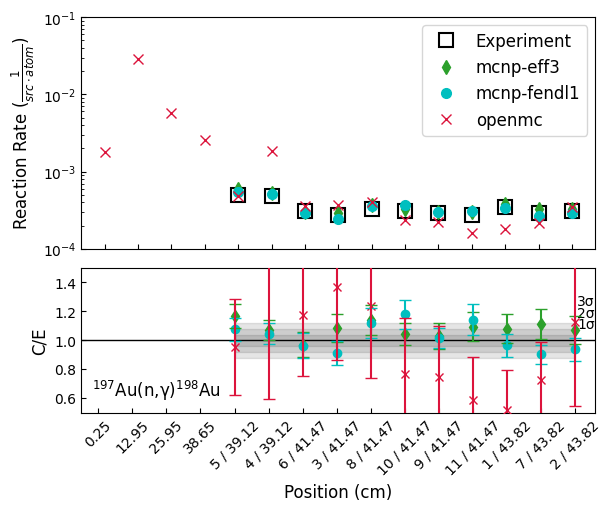

In [5]:
# initialization
path = 'reaction_rates_offaxis/'
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

for i,foil in enumerate(foil_list):

    # read measured and mcnp results from sinbad file
    measured = sinbad_file[path + f'measured/{foil}/table']
    mcnp_eff3 = sinbad_file[path + f'mcnp-eff3/{foil}/table']
    mcnp_fendl1 = sinbad_file[path + f'mcnp-fendl1/{foil}/table']
    try:
        mcnp_fendl2 = sinbad_file[path + f'mcnp-fendl2/{foil}/table']
    except:
        mcnp_fendl2 = None

    # read openmc results from its statepoint file
    openmc_1 = helpers.get_openmc_tally('reaction_rates_offaxis', 'statepoint.100.h5', f'{foil}_irdff_rr')
    openmc_1 = helpers.postprocess_openmc_foils(openmc_1, 'offaxis')
    
    # plot
    dtype_label = reaction_labels[i]
    foils_offaxis = helpers.VisualizeResults()  # the plot has always to be initialized like this
    foils_offaxis.add_measured_data(measured, ylabel, dtype_label)  # measured data have always to be plotted
    foils_offaxis.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
    foils_offaxis.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
    foils_offaxis.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
    foils_offaxis.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')

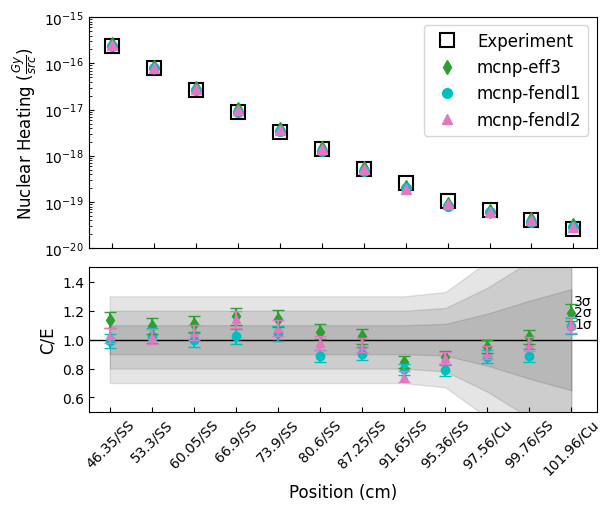

In [6]:
# initialization
path = 'heating/'
ylabel = r'Nuclear Heating $(\frac{Gy}{src})$'

measured = sinbad_file[path + f'measured/table']
mcnp_eff3 = sinbad_file[path + f'mcnp-eff3/table']
mcnp_fendl1 = sinbad_file[path + f'mcnp-fendl1/table']
mcnp_fendl2 = sinbad_file[path + f'mcnp-fendl2/table']

qtld_coeffs = sinbad_file['heating/qtld_coefficients/table']
openmc_1 = helpers.get_openmc_tally('heating', 'statepoint.100.h5', 'heating_dose')
openmc_1 = helpers.postprocess_openmc_heating(openmc_1, qtld_coeffs)

nuclear_heating = helpers.VisualizeResults()  # the plot has always to be initialized like this
nuclear_heating.add_measured_data(measured, ylabel, dtype_label='')  # measured data have always to be plotted
nuclear_heating.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
nuclear_heating.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
nuclear_heating.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
nuclear_heating.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')